## Show CL spread histories to see how large contangos and backwardations have been.

In [1]:
import zipfile
import glob
import pandas as pd
import numpy as np

from argparse import ArgumentParser
from argparse import RawDescriptionHelpFormatter
import sys
import os
if  not './' in sys.path:
    sys.path.append('./')
if  not '../' in sys.path:
    sys.path.append('../')

from barchartacs import build_db
from barchartacs import db_info
import plotly.graph_objs as go
from plotly.offline import  init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.tools as tls
from plotly.graph_objs.layout import Font,Margin
from IPython import display

import datetime
import io
from tqdm import tqdm,tqdm_notebook
from barchartacs import pg_pandas as pg
import mibian
import py_vollib
import importlib
from py_vollib import black
from py_vollib.black import implied_volatility
import ipdb
import traceback
import pandas_datareader.data as pdr
from scipy.stats import norm

from ipysheet import from_dataframe,to_dataframe
# importlib.reload(build_db)

/Users/bperlman1/Virtualenvs3/dashrisk4/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



## IF YOU WANT TO SEE WARNINGS, COMMENT THIS OUT

In [2]:
import warnings
warnings.filterwarnings("ignore")

### important global variables

In [3]:

DEBUG_IT=False
opttab = 'sec_schema.options_table'
futtab = 'sec_schema.underlying_table'
USE_PYVOL = True

# df_expiry_dates_additions = pd.read_csv('df_expiry_dates_additions.csv')
df_expiry_dates_additions = pd.read_csv('live_option_expirations.csv')


#### get all contracts in the options database

In [4]:
pga = db_info.get_db_info()
print(f"futtab max date: {pga.get_sql(f'select max(settle_date) from {futtab}')}")
print(f"opttab max date: {pga.get_sql(f'select max(settle_date) from {opttab}')}")


  sec_db
futtab max date:         max
0  20200323
opttab max date:         max
0  20200323


In [5]:
def plotly_plot(df_in,x_column,plot_title=None,
                y_left_label=None,y_right_label=None,
                bar_plot=False,width=800,height=400,
                number_of_ticks_display=20,
                yaxis2_cols=None,
                x_value_labels=None):
    ya2c = [] if yaxis2_cols is None else yaxis2_cols
    ycols = [c for c in df_in.columns.values if c != x_column]
    # create tdvals, which will have x axis labels
    td = list(df_in[x_column]) 
    nt = len(df_in)-1 if number_of_ticks_display > len(df_in) else number_of_ticks_display
    spacing = len(td)//nt
    tdvals = td[::spacing]
    tdtext = tdvals
    if x_value_labels is not None:
        tdtext = [x_value_labels[i] for i in tdvals]
    
    # create data for graph
    data = []
    # iterate through all ycols to append to data that gets passed to go.Figure
    for ycol in ycols:
        if bar_plot:
            b = go.Bar(x=td,y=df_in[ycol],name=ycol,yaxis='y' if ycol not in ya2c else 'y2')
        else:
            b = go.Scatter(x=td,y=df_in[ycol],name=ycol,yaxis='y' if ycol not in ya2c else 'y2')
        data.append(b)

    # create a layout
    layout = go.Layout(
        title=plot_title,
        xaxis=dict(
            ticktext=tdtext,
            tickvals=tdvals,
            tickangle=45,
            type='category'),
        yaxis=dict(
            title='y main' if y_left_label is None else y_left_label
        ),
        yaxis2=dict(
            title='y alt' if y_right_label is None else y_right_label,
            overlaying='y',
            side='right'),
        autosize=False,
        width=width,
        height=height,
        margin=Margin(
            b=100
        )        
    )

    fig = go.Figure(data=data,layout=layout)
    fig.update_layout(
        title={
            'text': plot_title,
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'})
    return fig

def plotly_shaded_rectangles(beg_end_date_tuple_list,fig):
    ld_shapes = []
    for beg_end_date_tuple in beg_end_date_tuple_list:
        ld_beg = beg_end_date_tuple[0]
        ld_end = beg_end_date_tuple[1]
        ld_shape = dict(
            type="rect",
            # x-reference is assigned to the x-values
            xref="x",
            # y-reference is assigned to the plot paper [0,1]
            yref="paper",
            x0=ld_beg[i],
            y0=0,
            x1=ld_end[i],
            y1=1,
            fillcolor="LightSalmon",
            opacity=0.5,
            layer="below",
            line_width=0,
        )
        ld_shapes.append(ld_shape)

    fig.update_layout(shapes=ld_shapes)
    return fig

### Larges CL contangos

In [8]:
sql_all_cl = f"""
select settle_date,symbol,close from {futtab} where substring(symbol,1,2)='CL'
"""
df_all_cl = pga.get_sql(sql_all_cl)

In [9]:
df_syms = pd.DataFrame({'symbol':df_all_cl.symbol.unique()})
df_syms['ssyym'] = df_syms.symbol.apply(lambda s:f'{s[0:2]}{s[-2:]}{s[2]}')
df_syms = df_syms.sort_values('ssyym')
allc_ordered = df_syms.symbol.values



### Create a DataFrame whose columns contain the closing values for successive contract months in CL
1. ```df_final`` contains columns in the form ```m1, m2, ...,m12```
2. Each column holds a closing price for that month


In [10]:
final_yyyymmdd = df_all_cl.settle_date.max()
df_final = None
beg_date = 20100101
# loop on all contracts in allc_ordered
for i in tqdm_notebook(range(len(allc_ordered))):
    # get 12 contracts at a time, starting with contract allc_ordered[i]
    current_12 = allc_ordered[i:i+12] 
    # get settle_data and close of allc_contract[i]
    df_m1 = df_all_cl[(df_all_cl.symbol==current_12[0]) & (df_all_cl.settle_date>beg_date)][['settle_date','close']]
    # rename close to 'm1' for month 1
    df_m1 = df_m1.rename(columns={'close':'m1'})
    df_m1.index = list(range(len(df_m1)))
    # now loop on next 11 contracts, and append a column to df_m1 for the close of those successive months
    for j in range(1,12):
        df_m_j = df_all_cl[(df_all_cl.symbol==current_12[j]) & (df_all_cl.settle_date>beg_date)][['settle_date','close']]
        df_m_j = df_m_j.rename(columns={'close':f'm{j+1}'})
        df_m_j.index = list(range(len(df_m_j)))
        df_m1 =  df_m1.merge(df_m_j,on='settle_date',how='inner')
    # now that you have 12 month columns
    if df_final is None:
        df_final = df_m1.copy()
    else:
        df_final = df_final.append(df_m1,ignore_index=True)
    if df_final.settle_date.max()>=final_yyyymmdd:
        break
    beg_date = df_final.settle_date.max()


In [11]:
len(df_final)

2406

### Create a single DataFrame showing one-month spread values for each day in CL
1. ```df_final_spread``` contains columns in the form ```sm2_m1, sm3_m2, ..., sm12_m11, sm12-m1```
2. Each column holds a spread between month n and month n-1
3. The last column holds the spread between month 12 and month 1


In [12]:
df_final_spread = df_final[['settle_date']]
for i in range(2,13):
    mfront = f'm{i-1}'
    mback = f'm{i}'    
    df_final_spread[f's{mback}_{mfront}'] = df_final[mback] - df_final[mfront]
spread_cols = [c  for c in df_final_spread.columns.values if c != 'settle_date']
df_final_spread['sm12_m1'] = df_final_spread.apply(lambda r:sum([r[c] for c in spread_cols]),axis=1) 


2020-03-24 08:10:01,667 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


In [13]:
df_final_spread

,settle_date,sm2_m1,sm3_m2,sm4_m3,sm5_m4,sm6_m5,sm7_m6,sm8_m7,sm9_m8,sm10_m9,sm11_m10,sm12_m11,sm12_m1
0,20100901,1.45,1.50,1.04,0.81,0.66,0.49,0.46,0.43,0.40,0.33,0.32,7.89
1,20100902,1.22,1.25,0.94,0.79,0.66,0.49,0.43,0.41,0.39,0.31,0.30,7.19
2,20100903,1.37,1.32,0.96,0.79,0.65,0.47,0.41,0.39,0.38,0.32,0.31,7.37
3,20100907,1.76,1.62,1.26,0.88,0.68,0.48,0.42,0.40,0.39,0.34,0.33,8.56
4,20100909,1.54,1.44,1.04,0.81,0.67,0.50,0.44,0.40,0.37,0.30,0.29,7.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2401,20200317,0.38,0.72,0.91,0.90,0.85,0.78,0.76,0.68,0.59,0.53,0.48,7.58
2402,20200318,0.46,1.10,1.29,1.22,1.13,0.99,0.90,0.81,0.69,0.63,0.58,9.80
2403,20200319,0.69,0.88,1.17,1.05,0.89,0.75,0.68,0.59,0.50,0.47,0.43,8.10
2404,20200320,0.20,1.73,1.57,1.17,0.92,0.78,0.72,0.64,0.54,0.49,0.46,9.22


In [14]:
df_final_spread.to_csv('temp_folder/cl_spread_history.csv',index=False)

-14.030000000000001 14.049999999999997


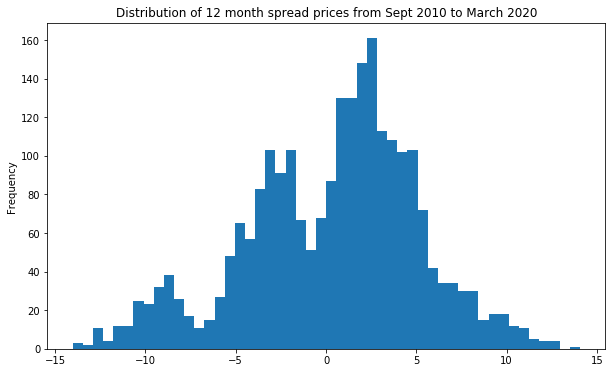

In [15]:
print(df_final_spread.sm12_m1.min(),df_final_spread.sm12_m1.max())
t = "Distribution of 12 month spread prices from Sept 2010 to March 2020"
df_final_spread.sm12_m1.plot(kind='hist',bins=50,figsize=(10,6),title=t)

In [16]:
df_biggest_containgos = df_final_spread.sort_values('sm12_m1',ascending=False).head(10)
df_biggest_containgos.index = list(range(len(df_biggest_containgos)))
df_recent_containgos = df_final_spread[df_final_spread.settle_date>=20200301].tail()
df_recent_containgos.index = list(range(len(df_recent_containgos)))
df_biggest_containgos.to_csv('temp_folder/df_biggest_containgos.csv',index=False)
df_recent_containgos.to_csv('temp_folder/df_recent_containgos.csv',index=False)


In [17]:
df_biggest_containgos

,settle_date,sm2_m1,sm3_m2,sm4_m3,sm5_m4,sm6_m5,sm7_m6,sm8_m7,sm9_m8,sm10_m9,sm11_m10,sm12_m11,sm12_m1
0,20110214,3.92,3.53,1.98,1.34,0.83,0.55,0.46,0.43,0.39,0.35,0.27,14.05
1,20110215,3.25,3.29,1.82,1.28,0.82,0.56,0.46,0.42,0.38,0.33,0.25,12.86
2,20110209,3.39,3.09,1.94,1.27,0.79,0.53,0.48,0.41,0.37,0.31,0.24,12.82
3,20110211,3.55,3.22,1.79,1.20,0.71,0.47,0.41,0.40,0.37,0.32,0.25,12.69
4,20110216,2.85,3.12,1.86,1.31,0.84,0.60,0.50,0.45,0.38,0.32,0.24,12.47
5,20110208,3.30,2.88,1.77,1.19,0.77,0.50,0.45,0.39,0.36,0.29,0.23,12.13
6,20110210,3.21,2.98,1.76,1.19,0.73,0.48,0.43,0.38,0.36,0.31,0.24,12.07
7,20110218,3.51,2.60,1.51,1.11,0.73,0.58,0.50,0.46,0.38,0.35,0.25,11.98
8,20150318,1.99,2.04,1.67,1.33,0.99,0.77,0.71,0.69,0.62,0.57,0.54,11.92
9,20150226,2.22,1.71,1.59,1.37,1.09,0.83,0.70,0.63,0.55,0.56,0.55,11.80


In [18]:
df_recent_containgos

,settle_date,sm2_m1,sm3_m2,sm4_m3,sm5_m4,sm6_m5,sm7_m6,sm8_m7,sm9_m8,sm10_m9,sm11_m10,sm12_m11,sm12_m1
0,20200317,0.38,0.72,0.91,0.90,0.85,0.78,0.76,0.68,0.59,0.53,0.48,7.58
1,20200318,0.46,1.10,1.29,1.22,1.13,0.99,0.90,0.81,0.69,0.63,0.58,9.80
2,20200319,0.69,0.88,1.17,1.05,0.89,0.75,0.68,0.59,0.50,0.47,0.43,8.10
3,20200320,0.20,1.73,1.57,1.17,0.92,0.78,0.72,0.64,0.54,0.49,0.46,9.22
4,20200323,2.12,1.75,1.21,0.95,0.78,0.71,0.62,0.52,0.47,0.44,0.40,9.97


In [19]:
sql_cl_one_day = f"""
select settle_date,symbol,close from {futtab} where settle_date = 20200323
and substring(symbol,1,2)='CL'
"""
pga.get_sql(sql_cl_one_day).iloc[:14]

,settle_date,symbol,close
0,20200323,CLZ99,23.78
1,20200323,CLK20,23.36
2,20200323,CLM20,25.48
3,20200323,CLN20,27.23
4,20200323,CLQ20,28.44
5,20200323,CLU20,29.39
6,20200323,CLV20,30.17
7,20200323,CLX20,30.88
8,20200323,CLZ20,31.50
9,20200323,CLF21,32.02
